In [70]:
import pandas as pd
import numpy as np
from numpy import random 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

The three functions below add several numerical features to my dataset. The first function, all_time_win_ratio, maps every team's all time win ratio to the opponent column. The second function, win_ratio_head2head, maps the selected team's head to head win ratio vs each opponent to the opponent column. The final function, add_league_position, maps the league position for each team in that season to the opponent column.

In [2]:
def all_time_win_ratio(df):
    team_list = df.HomeTeam.unique()
    all_time_ratio = {}
    for team in team_list:
        all_games = df.loc[(slice(None),team),:]
        win_ratio = len(all_games[all_games['Points'] == 3])/len(all_games)
        all_time_ratio[team] = win_ratio
    df['opp_win_ratio'] = df['opponent'].map(all_time_ratio)
    return df

def win_ratio_head2head(df):
    team_list = df.HomeTeam.unique()
    chunks = []
    for team in team_list:
        team_games = df[df['team'] == team]
        head2head = {}
        opponents = team_games['opponent'].unique()
        for opponent in opponents:
            wins = len(team_games.loc[(team_games['opponent']==opponent) & (team_games['Points'] == 3)])
            total = len(team_games.loc[(team_games['opponent'] == opponent)])
            if wins > 0:
                win_ratio = wins/total
            else:
                win_ratio = 0
            head2head[opponent] = win_ratio
        team_games['head2head_win_ratio'] = team_games['opponent'].map(head2head)
        chunks.append(team_games)
    dataframe = pd.concat(chunks,ignore_index=True)
    return dataframe

def add_league_position(df1,df2):
    seasons_list1 = double_df['Season'].unique()
    seasons_list2 = seasons.year.unique()
    seasons_offset = [x for x in seasons_list1 if x in seasons_list2]
    seasons_offset.remove('1993-94')
    seasons_list1 = double_df['Season'].unique()
    seasons_list2 = seasons.year.unique()
    seasons_list = [x for x in seasons_list1 if x in seasons_list2]
    seasons_list.remove('2016-17')
    chunk_list = []
    for i in range(len(seasons_offset)):
        current = df2[df2['year']==seasons_list[i]]
        teams = current['Team']
        pos = current['Pos']
        dictionary = dict(zip(teams,pos))
        chunk = df1[df1['Season']==seasons_offset[i]]
        chunk['Opp_League_Finish_Last_Year'] = chunk['opponent'].map(dictionary)
        chunk_list.append(chunk)
    dataframe = pd.concat(chunk_list,ignore_index=True)
    return dataframe

def home_away_numerical(df):
    team_list = df.HomeTeam.unique()
    chunks = []
    for team in team_list:
        all_games = df[df['team']==team]
        all_games['HomeAway'] = 1
        all_games.loc[all_games['AwayTeam']==team,'HomeAway'] = 0
        chunks.append(all_games)
    dataframe = pd.concat(chunks,ignore_index=True)
    return dataframe

def win_streak(df):
    team_list = df['HomeTeam'].unique()
    chunk_list = []
    for team in team_list:
        team_games = double_df.loc[(slice(None),team),:]
        streak_list = []
        streak = 0
        for (season, team, date), data in team_games.iterrows():
            if data['Points'] == 3:
                streak_list.append(streak)
                streak += 1
            elif data['Points'] != 3: 
                streak_list.append(streak)
                streak = 0
        team_games['Streak'] = streak_list
        chunk_list.append(team_games)
    dataframe = pd.concat(chunk_list)
    return dataframe

def home_away_points(df, season):
    team_list = df.loc[season]['HomeTeam'].unique()
    home_points= []
    away_points = []
    for team in team_list:
        team_df = df.loc[(season,team)]
        home = team_df['HomeTeam'] == team
        away = team_df['AwayTeam'] == team
        home_points.append(team_df.loc[home,'Points'].mean().round(2))
        away_points.append(team_df.loc[away, 'Points'].mean().round(2))
    dataframe = pd.DataFrame({'Teams':team_list,'Mean Home Points':home_points,'Mean Away Points' : away_points})
    dataframe.set_index('Teams', inplace=True)
    dataframe.plot(kind='Bar',title='Mean Home and Away Points in ' + season)
    
def cumulative_points(df,season):
    team_list = df.loc[season]['HomeTeam'].unique()
    most_least_list = []
    most_least_dict = {}
    for team in team_list:
        last_year = df.loc[(season,team)]
        most_least_list.append(last_year['Points'].sum())
        most_least_dict[last_year['Points'].sum()] = team
    most_least_list = sorted(most_least_list)
    best_team = df.loc[(season,most_least_dict[most_least_list[-1]])]
    mid_team = df.loc[(season,most_least_dict[most_least_list[9]])]
    worst_team = df.loc[(season,most_least_dict[most_least_list[0]])]
    best_team = best_team.reset_index(drop=True)
    mid_team = mid_team.reset_index(drop=True)
    worst_team = worst_team.reset_index(drop=True)
    best_cum_points = best_team['Points'].cumsum()
    best_cum_randoms = best_team['Random Points'].cumsum()
    mid_cum_points = mid_team['Points'].cumsum()
    mid_cum_randoms = mid_team['Random Points'].cumsum()
    worst_cum_points = worst_team['Points'].cumsum()
    worst_cum_randoms = worst_team['Random Points'].cumsum()
    best_cum_points.plot(color='blue',label='Top Team Real Results')
    best_cum_randoms.plot(color='red',label='Top Team Random Results')
    mid_cum_points.plot(color='green', label = 'Mid Table Team Real Results')
    mid_cum_randoms.plot(color='yellow', label='Mid Table Team Random Results')
    worst_cum_points.plot(color='brown',label='Bottom Team Real Results')
    worst_cum_randoms.plot(color='black',label='Bottom Team Random Results')
    plt.xlabel('Games')
    plt.ylabel('Points')
    plt.title("Point Total from " + season + ': Expected vs. Actual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

##function to filter a team's results by w/d/l and add the points to the df
def results_and_points(df, team_list):
    for team in team_list:    
        real_win = ((df['team'] == team) & (df['HomeTeam'] == team) & (df['FTR'] =='H')) |((df['team'] == team) & (df['AwayTeam'] ==team) & (df['FTR'] =='A'))
        real_tie = ((df['team'] == team) & (df['HomeTeam'] == team) & (df['FTR'] =='D')) |((df['team'] == team) & (df['AwayTeam'] ==team) & (df['FTR'] =='D'))
        real_loss = ((df['team'] == team) & (df['HomeTeam'] == team) & (df['FTR'] =='A')) |((df['team'] == team) & (df['AwayTeam'] ==team) & (df['FTR'] =='H'))
        random_win = ((df['team'] == team) & (df['HomeTeam'] == team) & (df['randomResult'] =='H')) |((df['team'] == team) & (df['AwayTeam'] ==team) & (df['randomResult'] =='A'))
        random_tie = ((df['team'] == team) & (df['HomeTeam'] == team) & (df['randomResult'] =='D')) |((df['team'] == team) & (df['AwayTeam'] ==team) & (df['randomResult'] =='D'))
        random_loss = ((df['team'] == team) & (df['HomeTeam'] == team) & (df['randomResult'] =='A')) |((df['team'] == team) & (df['AwayTeam'] ==team) & (df['randomResult'] =='H'))
        df.loc[real_win,'Points']=3
        df.loc[real_tie,'Points']=1
        df.loc[real_loss, 'Points']=0
        df.loc[random_win, 'Random Points'] = 3
        df.loc[random_tie, 'Random Points'] = 1
        df.loc[random_loss, 'Random Points'] = 0
    return df
    

In [3]:
#Loading in a dataframe of match results and season results and cleaning columns
original_df = pd.read_csv('EPL_Match_Results.csv')
original_df = original_df[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Season']]
original_df['Date'] = pd.to_datetime(original_df['Date'],dayfirst=True)
#Adding random results with a random integer and changing all the 2's to 3's
original_df['randomResult'] = np.random.randint(0,3,len(original_df))

away_win = original_df['randomResult'] == 0
draw = original_df['randomResult'] == 1
home_win = original_df['randomResult'] == 2
                  
original_df.loc[home_win,'randomResult'] = 'H'
original_df.loc[draw, 'randomResult'] = 'D'
original_df.loc[away_win, 'randomResult'] = 'A'

seasons = pd.read_csv('seasons_result.csv',index_col= 'year')
seasons = seasons.loc['2016/2017':'1993/1994'][['Team','W','L','D','F','A','Pts','Pos']]
seasons = seasons.reset_index()
seasons['year'] = seasons['year'].str.slice_replace(4,7,'-')
seasons['Team'] = seasons['Team'].str.replace('Manchester United', 'Man United')
seasons['Team'] = seasons['Team'].str.replace('Manchester City', 'Man City')
seasons['Team'] = seasons['Team'].str.replace('Tottenham Hotspurs', 'Tottenham')
seasons['Team'] = seasons['Team'].str.replace('West Bromwich Albion', 'West Brom')
seasons['Team'] = seasons['Team'].str.replace('Birmingham City', 'Birmingham')
seasons['Team'] = seasons['Team'].str.replace('Blackburn Rovers', 'Blackburn')
seasons['Team'] = seasons['Team'].str.replace('Bolton Wanderers', 'Bolton')
seasons['Team'] = seasons['Team'].str.replace('Bradford City', 'Bradford')
seasons['Team'] = seasons['Team'].str.replace('Cardiff City', 'Cardiff')
seasons['Team'] = seasons['Team'].str.replace('Charlton Athletic', 'Charlton')
seasons['Team'] = seasons['Team'].str.replace('Coventry City', 'Coventry')
seasons['Team'] = seasons['Team'].str.replace('Derby County', 'Derby')
seasons['Team'] = seasons['Team'].str.replace('Hull City', 'Hull')
seasons['Team'] = seasons['Team'].str.replace('Ipswich Town', 'Ipswich')
seasons['Team'] = seasons['Team'].str.replace('Leeds United', 'Leeds')
seasons['Team'] = seasons['Team'].str.replace('Leicester City', 'Leicester')
seasons['Team'] = seasons['Team'].str.replace('Newcastle United', 'Newcastle')
seasons['Team'] = seasons['Team'].str.replace('Norwich City', 'Norwich')
seasons['Team'] = seasons['Team'].str.replace('Nottingham Forest', "Nott'm Forest")
seasons['Team'] = seasons['Team'].str.replace('Queens Park Rangers', 'QPR')
seasons['Team'] = seasons['Team'].str.replace('Oldham Athletic','Oldham')
seasons['Team'] = seasons['Team'].str.replace('Sheffield Wednesday', 'Sheffield Weds')
seasons['Team'] = seasons['Team'].str.replace('Stoke City', 'Stoke')
seasons['Team'] = seasons['Team'].str.replace('Swansea City', 'Swansea')
seasons['Team'] = seasons['Team'].str.replace('Swindon Town', 'Swindon')
seasons['Team'] = seasons['Team'].str.replace('West Bromwich Albion', 'West Brom')
seasons['Team'] = seasons['Team'].str.replace('West Ham United','West Ham')
seasons['Team'] = seasons['Team'].str.replace('Wolverhampton Wanderers','Wolves')


seasons['year'] = seasons['year'].str.replace('2002-','2002-03')
seasons['year'] = seasons['year'].str.replace('2003-','2003-04')
seasons['year'] = seasons['year'].str.replace('2004-','2004-05')
seasons['year'] = seasons['year'].str.replace('2005-','2005-06')

team_list = []
team_list = original_df.HomeTeam.unique()
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
print(original_df.head(10))

        Date          HomeTeam        AwayTeam  FTHG  FTAG FTR   Season randomResult
0 1993-08-14           Arsenal        Coventry     0     3   A  1993-94            D
1 1993-08-14       Aston Villa             QPR     4     1   H  1993-94            D
2 1993-08-14           Chelsea       Blackburn     1     2   A  1993-94            H
3 1993-08-14         Liverpool  Sheffield Weds     2     0   H  1993-94            A
4 1993-08-14          Man City           Leeds     1     1   D  1993-94            D
5 1993-08-14         Newcastle       Tottenham     0     1   A  1993-94            H
6 1993-08-14            Oldham         Ipswich     0     3   A  1993-94            D
7 1993-08-14  Sheffield United         Swindon     3     1   H  1993-94            H
8 1993-08-14       Southampton         Everton     0     2   A  1993-94            H
9 1993-08-14          West Ham       Wimbledon     0     2   A  1993-94            D


The following cell turns the dataframe I originally loaded into the format I need for analyzing matches. I had to copy the original and make new columns for both so that when I concatenated them together I could have all of a team's games represented in order by season.

In [43]:
pd.options.mode.chained_assignment = None
original_df1 = original_df.copy()
original_df1['team'] = original_df1['HomeTeam']
original_df1['opponent'] = original_df1['AwayTeam']
original_df['team'] = original_df1['AwayTeam']
original_df['opponent'] = original_df1['HomeTeam']
double_df = pd.concat([original_df,original_df1])
double_df = results_and_points(double_df, team_list)
double_df = win_ratio_head2head(double_df)
double_df = home_away_numerical(double_df)
double_df = add_league_position(double_df,seasons)
double_df.set_index(['Season','team','Date'], inplace=True)
double_df.sort_index(inplace=True, level = [0,1,2])
double_df = all_time_win_ratio(double_df)
double_df = win_streak(double_df)
double_df.sort_index(inplace=True, level = [0,1,2])
double_df['Opp_League_Finish_Last_Year'].fillna(20,inplace=True)
double_df['Result'] = 'Win'
double_df.loc[double_df['Points'] == 1, 'Result'] = 'Draw'
double_df.loc[double_df['Points']== 0, 'Result'] = 'Loss'
double_df.head()

HomeTeam   AwayTeam  FTHG  FTAG FTR   ...   HomeAway Opp_League_Finish_Last_Year  opp_win_ratio  Streak  Result
Season  team    Date                                               ...                                                                      
1994-95 Arsenal 1994-08-20    Arsenal   Man City     3     0   H   ...          1                        16.0       0.436923       0     Win
                1994-08-23      Leeds    Arsenal     1     0   H   ...          0                         5.0       0.414062       1    Loss
                1994-08-28  Liverpool    Arsenal     3     0   H   ...          0                         8.0       0.510714       0    Loss
                1994-08-31    Arsenal  Blackburn     0     0   D   ...          1                         2.0       0.354575       0    Draw
                1994-09-10    Norwich    Arsenal     0     0   D   ...          0                        12.0       0.242268       0    Draw

[5 rows x 15 columns]

In [86]:
# Two sample ttest for difference in mean points home and away across all seasons. Statistically significant.
team = double_df.loc[(slice(None),'Watford'),:]
home = team['HomeTeam'] == 'Watford'
away = team['AwayTeam'] == 'Watford'
x = team[home]['Points']
y = team[away]['Points']
t,p = stats.ttest_ind(x,y)
print(t,p)

3.2169247842974165 0.0016943575091204052


In [75]:
all_games_modeled = pd.get_dummies(double_df,prefix = ['opp'], columns = ['opponent'])
train = all_games_modeled.loc['1994-95':'2015-16']
X_train = train.drop(['FTHG','FTAG','HomeTeam','AwayTeam', 'Random Points','randomResult','FTR','Points','Result'],axis = 1)
y_train = train['Result']
test = all_games_modeled.loc['2016-17']
X_test = test.drop(['FTHG','FTAG','HomeTeam','AwayTeam', 'Random Points','randomResult','FTR','Points','Result'],axis = 1)
y_test = test['Result']
logreg_grid = LogisticRegression(multi_class='multinomial',solver = 'lbfgs',max_iter=1000)
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
CLF = GridSearchCV(logreg_grid,params,cv = 5,scoring='accuracy')
CLF.fit(X_train,y_train)
CLF.best_params_

In [78]:
logreg = LogisticRegression(multi_class='multinomial',solver = 'lbfgs',max_iter=1000, C = 0.1)
logreg.fit(X_train,y_train)
logreg.score(X_test,y_test)

0.5973684210526315

In [85]:
all_games_modeled = pd.get_dummies(double_df,prefix = ['opp'], columns = ['opponent'])
train = all_games_modeled.loc['1994-95':'2015-16']
X_train = train.drop(['FTHG','FTAG','HomeTeam','AwayTeam', 'Random Points','randomResult','FTR','Points','Result'],axis = 1)
y_train = train['Points']
test = all_games_modeled.loc['2016-17']
X_test = test.drop(['FTHG','FTAG','HomeTeam','AwayTeam', 'Random Points','randomResult','FTR','Points','Result'],axis = 1)
y_test = test['Points']
rf_grid = RandomForestClassifier(max_features='sqrt')
params = {'n_estimators':[250,500,750],'max_depth': np.linspace(7,13,6)}
clf = GridSearchCV(rf_grid,params,cv = 5,scoring='accuracy')
clf.fit(X_train,y_train)
print(clf.best_params_,clf.best_score_)

{'max_depth': 8.2, 'n_estimators': 500} 0.5316918878690151


In [86]:
rf = RandomForestClassifier(max_features = 'sqrt', n_estimators = 500, max_depth = 8.2 )
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.5973684210526315

In [89]:
top_teams_model = double_df.loc[(slice(None),['Arsenal','Chelsea','Man United','Liverpool']),:]
top_teams_model = pd.get_dummies(top_teams_model,prefix = ['opp'], columns = ['opponent'])
train_topteams = top_teams_model.loc['1994-95':'2015-16']
X_train_topteams = train_topteams.drop(['FTHG','FTAG','HomeTeam','AwayTeam', 'Random Points','randomResult','FTR','Points','Result'],axis = 1)
y_train_topteams = train_topteams['Points']
test_topteams = top_teams_model.loc['2016-17']
X_test_topteams = test_topteams.drop(['FTHG','FTAG','HomeTeam','AwayTeam', 'Random Points','randomResult','FTR','Points','Result'],axis = 1)
y_test_topteams = test_topteams['Points']
rf_top = RandomForestClassifier(max_features='sqrt',n_estimators=500, max_depth=8 )
rf_top.fit(X_train_topteams,y_train_topteams)
rf_top.score(X_test_topteams,y_test_topteams)

0.6381578947368421

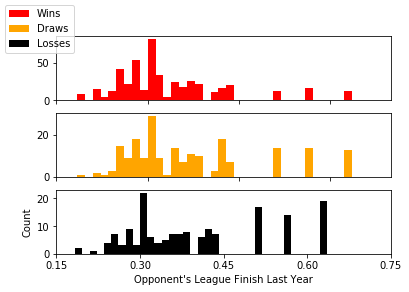

In [82]:
chelsea = double_df.loc[(slice(None),'Arsenal'),:]
chelseawin = chelsea[chelsea['Points'] == 3]
chelseadraw = chelsea[chelsea['Points'] == 1]
chelsealoss = chelsea[chelsea['Points'] == 0]
x = chelseawin['opp_win_ratio']
y = chelseadraw['opp_win_ratio']
z = chelsealoss['opp_win_ratio']
fig, axs = plt.subplots(nrows = 3,ncols = 1,sharex = True,sharey=False)
axs[0].hist(x,bins=35,label='Wins',color = 'red')
axs[1].hist(y,bins=35,label='Draws',color='orange')
axs[2].hist(z,bins=35,label='Losses',color = 'black')
plt.xlabel("Opponent's League Finish Last Year")
plt.ylabel('Count')
plt.xlim(0.15,.7)
#plt.ylim(0,15)
plt.xticks([0.15,0.3,0.45,0.60,0.75])
plt.tight_layout
fig.legend(loc='upper left')
plt.show()

array([[ 1.        , -0.50608056],
       [-0.50608056,  1.        ]])

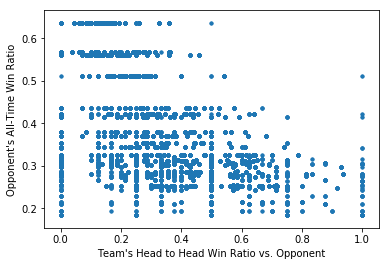

In [162]:
head2head_oppwin = double_df[['opp_win_ratio','head2head_win_ratio']]
head2head_oppwin.reset_index(inplace=True)
y=head2head_oppwin['opp_win_ratio']
x=head2head_oppwin['head2head_win_ratio']
plt.scatter(x,y, marker = '.')
plt.ylabel("Opponent's All-Time Win Ratio")
plt.xlabel("Team's Head to Head Win Ratio vs. Opponent")
np.corrcoef(x,y)